Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en `Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [709]:
#%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [710]:
def mostrar_img_grises(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()


def mostrar_img_bgr(img):
    plt.imshow(img[..., ::-1])
    plt.axis("off")
    plt.show()

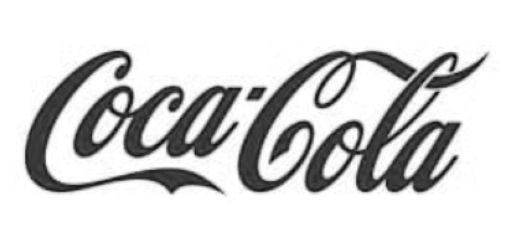

In [711]:
TEMPLATE_PATH = 'material/template/pattern.png'
template = cv.imread(TEMPLATE_PATH, 0)
mostrar_img_grises(template)

In [712]:
def check_sizes(template, img):
    if template.shape[0] > img.shape[0] or template.shape[1] > img.shape[1]:
        raise Exception('Invalid template size')

def do_template_matching(template, img_gray, method):
    check_sizes(template, img_gray)
    res = cv.matchTemplate(img_gray, template, eval(method))
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    if method in ['cv.TM_SQDIFF_NORMED', 'cv.TM_SQDIFF']:
        top_left = min_loc
        max_val_ncc = '{:.3f}'.format(min_val)
    else:
        top_left = max_loc
        max_val_ncc = '{:.3f}'.format(max_val)

    return max_val_ncc, top_left

def scale_img(scales, img):
    resized_imgs = list()
    for scale in scales:
        resized_imgs.append(cv.resize(img, None, fx=scale, fy=scale))
    return resized_imgs

def get_bottom_right(top_left, template, t_scale):
    w, h = template.shape[::-1]
    return int(top_left[0] + w * t_scale), int(top_left[1] + h * t_scale)

def draw_text(img, top_left, acc, color=(255, 0, 0)):
    label = f'Confianza: {int(float(acc) * 100)}%'
    (label_width, label_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 1, 2)

    text_start = (top_left[0], top_left[1] - label_height)
    text_end = (top_left[0] + label_width, top_left[1])

    font_scale = 1
    if text_end[0] > img.shape[1]:
        font_scale = 0.5

    cv.rectangle(img, text_start, text_end, (0,0,0),-1)
    cv.putText(img, label, top_left, cv.FONT_HERSHEY_SIMPLEX, font_scale, color, 2, cv.LINE_AA)

    return img

def draw_rectangle(img, top_left, bottom_right, acc, color=(255, 0, 0), thickness=3):
    cv.rectangle(img, top_left, bottom_right, color, thickness)
    draw_text(img, top_left, acc, color)
    return img

def draw_match(img, best_match):
    top_left = best_match[1]
    t_scale = best_match[2]
    bottom_right = get_bottom_right(top_left, template, t_scale)
    output_image = draw_rectangle(img, top_left, bottom_right)
    print('used', best_match[0], top_left, bottom_right, t_scale, best_match[3])
    return output_image

In [713]:
def preprocess_image(img, scale):
    scaled_img = cv.resize(img, None, fx=scale, fy=scale)
    canny_img = cv.Canny(scaled_img, 220, 260, apertureSize=3)
    return canny_img

def match_template(img, template, method, template_scale, image_scale):
    canny_template = preprocess_image(template, template_scale)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    canny_image = preprocess_image(img_gray, image_scale)

    max_val_ncc, top_left = do_template_matching(canny_template, canny_image, method)
    top_left = int(top_left[0]/image_scale), int(top_left[1]/image_scale)
    bottom_right = get_bottom_right(top_left, template, template_scale)
    output_image = draw_rectangle(img, top_left, bottom_right, max_val_ncc)
    return output_image

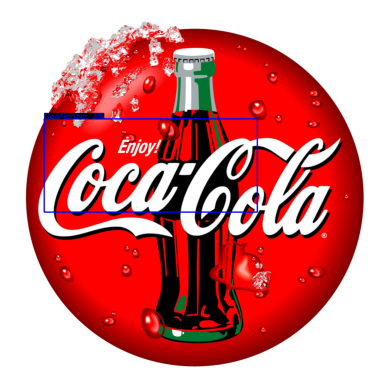

In [714]:
image = cv.imread('material/images/COCA-COLA-LOGO.jpg')
method = "cv.TM_CCOEFF_NORMED"
template_scale = 2
image_scale = 0.7

mostrar_img_bgr(match_template(image, template, method, template_scale, image_scale))

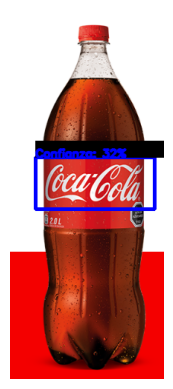

In [715]:
image = cv.imread('material/images/coca_logo_1.png')
method = "cv.TM_CCORR_NORMED"
template_scale = 0.4
image_scale = 1.0

mostrar_img_bgr(match_template(image, template, method, template_scale, image_scale))

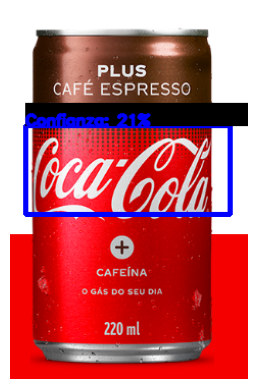

In [716]:
image = cv.imread('material/images/coca_logo_2.png')
method = "cv.TM_CCORR_NORMED"
template_scale = 0.5
image_scale = 1.0

mostrar_img_bgr(match_template(image, template, method, template_scale, image_scale))

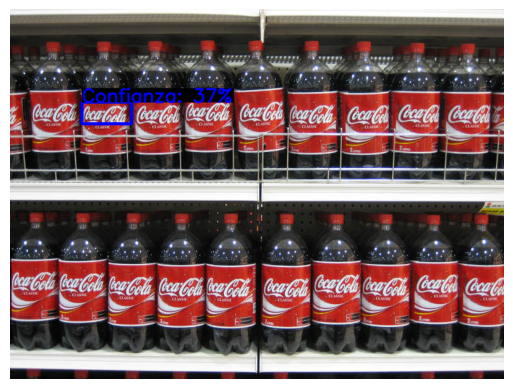

In [717]:
image = cv.imread('material/images/coca_multi.png')
method = "cv.TM_CCORR_NORMED"
template_scale = 0.2
image_scale = 1.0

mostrar_img_bgr(match_template(image, template, method, template_scale, image_scale))

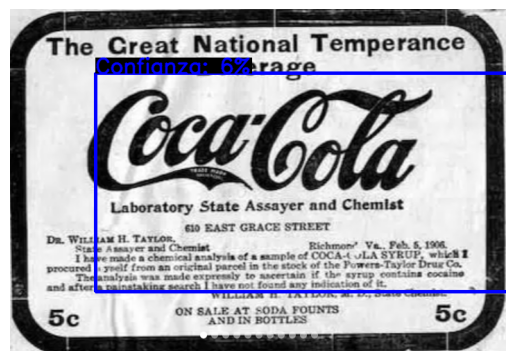

In [718]:
image = cv.imread('material/images/coca_retro_1.png')
method = "cv.TM_CCORR_NORMED"
template_scale = 1.8
image_scale = 2

mostrar_img_bgr(match_template(image, template, method, template_scale, image_scale))

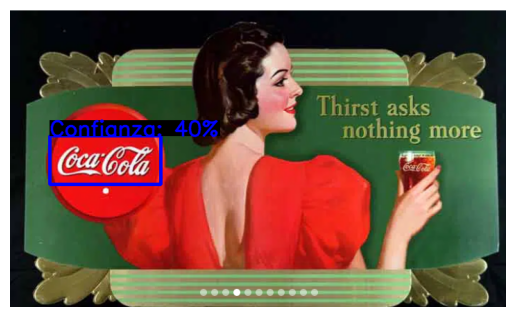

In [719]:
image = cv.imread('material/images/coca_retro_2.png')
method = "cv.TM_CCORR_NORMED"
template_scale = 0.4
image_scale = 1.0

mostrar_img_bgr(match_template(image, template, method, template_scale, image_scale))

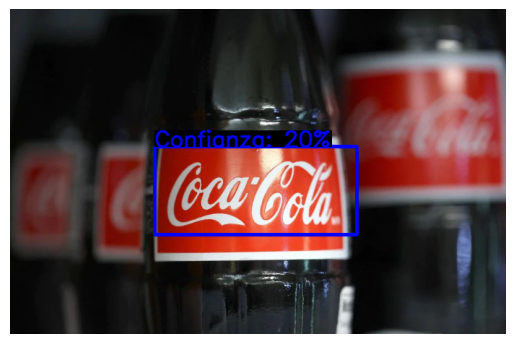

In [720]:
image = cv.imread('material/images/logo_1.png')
method = "cv.TM_CCORR_NORMED"
template_scale = 0.7
image_scale = 1.0

mostrar_img_bgr(match_template(image, template, method, template_scale, image_scale))

In [721]:
def remove_overlapping_matches(matches):
    to_keep = list()
    while len(matches) > 0:
        rect_1 = matches.pop(0)
        overlapped = False
        for rect in to_keep:
            if do_overlap(*rect_1, *rect):
                overlapped = True
                break
        if not overlapped:
            to_keep.append(rect_1)
    return to_keep


def do_overlap(tl1, br1, tl2, br2):
    if tl1[0] >= br2[0] or br1[0] <= tl2[0] or br1[1] <= tl2[1] or tl1[1] >= br2[1]:
        return False
    return True

In [722]:
def multi_match_template(img, template, method, template_scale, image_scale, threshold):
    canny_template = preprocess_image(template, template_scale)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    canny_image = preprocess_image(img_gray, image_scale)

    res = cv.matchTemplate(canny_image,canny_template, eval(method))
    loc = np.where(res >= threshold)
    output_image = img.copy()
    matches = list()
    for pt in zip(*loc[::-1]):
        top_left = int(pt[0]/image_scale), int(pt[1]/image_scale)
        bottom_right = get_bottom_right(top_left, template, template_scale)
        matches.append((top_left, bottom_right))

    matches = remove_overlapping_matches(matches)

    for top_left, bottom_right in matches:
        cv.rectangle(output_image, top_left, bottom_right, (255, 0, 0), 2)

    return output_image

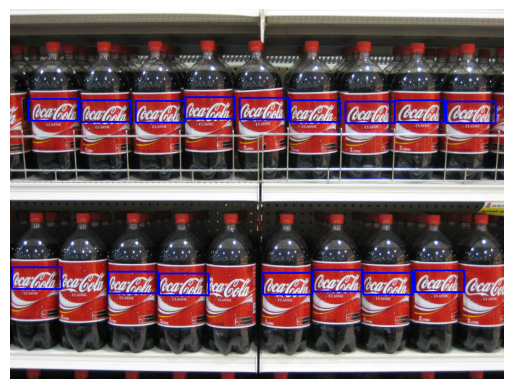

In [723]:
image = cv.imread('material/images/coca_multi.png')
method = "cv.TM_CCORR_NORMED"
template_scale = 0.2
image_scale = 1.0

mostrar_img_bgr(multi_match_template(image, template, method, template_scale, image_scale, 0.31))